## Ejercicio Banco

Vamos a tratar de predecir si un cliente es susceptible de contartar un producto o no de un banco. 

El dataset esta relacionado con una campaña de marketing de un banco portuges. La campaña de marketing se basaba en llamadas telefonicas. 

Las variables que encontramos en el dataset son las siguientes:

 Input variables:

<b>bank client data:</b>

1. age (numeric)
2. job : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student","blue-collar""self-employed", "retired","technician","services")
3. marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)
4. education (categorical: "unknown","secondary","primary","tertiary")
5. default: has credit in default? (binary: "yes","no")
6. balance: average yearly balance, in euros (numeric) 
7. housing: has housing loan? (binary: "yes","no")
8. loan: has personal loan? (binary: "yes","no")
   
<b>related with the last contact of the current campaign:</b>

9. contact: contact communication type (categorical: "unknown","telephone","cellular") 
10. day: last contact day of the month (numeric)
11. month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")
12. duration: last contact duration, in seconds (numeric)
   other attributes:
13. campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
14. pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)
15. previous: number of contacts performed before this campaign and for this client (numeric)
16. poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")

<b>Output variable (desired target):</b>

17. y - has the client subscribed a term deposit? (binary: "yes","no")

Libreria ara ML: https://scikit-learn.org/stable/index.html


In [4]:
## lo básico
import pandas as pd # libreria manejo de datos en dataframes
import numpy as np # librería calculos en arrays y numéricos 


#EDA
from itertools import combinations # para generar combinaciones de listas
from scipy.stats import chi2_contingency # para pruebas de independencia chi-cuadrado en tablas de contingencia

## visualización
import matplotlib.pyplot as plt 
import seaborn as sns 
import plotly.express as px
import plotly.graph_objects as go

## pre procesado
from sklearn.model_selection import train_test_split  # división datos entrenamiento y testeo
from sklearn.preprocessing import LabelEncoder # codificación variables categoricas label encoder

## modelado
from sklearn.ensemble import RandomForestClassifier # modelo clasificación bosques aleatorios
from sklearn.tree import DecisionTreeClassifier # modelo clasificación árbol de decisión

## métricas
from pandas.plotting import scatter_matrix # matrix de dispersión para visualización rápida de relaciones entre variables  
from sklearn.metrics import accuracy_score, auc, confusion_matrix, f1_score, precision_score, recall_score, roc_curve
# accuracy_score: exactitud global del modelo
# auc: área bajo la curva ROC
# confusion_matrix: matriz de confusión
# f1_score: media armónica entre precisión y recall
# precision_score: proporción de positivos predichos que son correctos
# recall_score: proporción de positivos reales detectados
# roc_curve: puntos para trazar la curva ROC
from sklearn.metrics import classification_report # Reporte con varias métricas por clase

## mejora de modelos
from sklearn.feature_selection import VarianceThreshold # elimina características con varianza baja
from sklearn.feature_selection import SelectKBest # Selecciona las k mejores características según una métrica
from sklearn.model_selection import GridSearchCV # Busqueda de hiperparámetros según una métrica
from imblearn.over_sampling import SMOTE # Aumenta muestras de clases minoritarias para balancear el dataset
from sklearn.model_selection import cross_val_score # evalúa un modelo con validación cruzada

## automatización
from sklearn.pipeline import Pipeline # Encadena pasos de preprocesado y modelado
from sklearn.preprocessing import OneHotEncoder, StandardScaler 
# OneHotEncoder: codifica variables categóricas a formato binario (0/1)
# StandardScaler: estandariza datos (media=0, desviación estándar=1)
from sklearn.compose import ColumnTransformer  # Aplica diferentes transformaciones a diferentes columnas
from sklearn.impute import SimpleImputer #Rellena valores faltantes (mediana, media, más freecuente, cosntante)


In [5]:
# Cargar datos
df = pd.read_csv(r'C:\Users\pauri\OneDrive\Escritorio\4) MÁSTER EN DATA SCIENCE, BIG DATA & BUSINESS ANALYTICS (UCM)\MÓDULO 8_MACHINE LEARNING\Clase 5, 6, 7 y 8\1. Ejercicio_banco\bank-full.csv')
df.head()

,"age;""job"";""marital"";""education"";""default"";""balance"";""housing"";""loan"";""contact"";""day"";""month"";""duration"";""campaign"";""pdays"";""previous"";""poutcome"";""y"""
0,"58;""management"";""married"";""tertiary"";""no"";2143..."
1,"44;""technician"";""single"";""secondary"";""no"";29;""..."
2,"33;""entrepreneur"";""married"";""secondary"";""no"";2..."
3,"47;""blue-collar"";""married"";""unknown"";""no"";1506..."
4,"33;""unknown"";""single"";""unknown"";""no"";1;""no"";""n..."


In [6]:
# Podemos osbervar que los datos no estan correctamente establecidos, pues se trata de un diccionario. para ello, debemos aplicar el separador ';' con el apartado sep
df = pd.read_csv(r'C:\Users\pauri\OneDrive\Escritorio\4) MÁSTER EN DATA SCIENCE, BIG DATA & BUSINESS ANALYTICS (UCM)\MÓDULO 8_MACHINE LEARNING\Clase 5, 6, 7 y 8\1. Ejercicio_banco\bank-full.csv',sep=';') # usamos sep = para indicar el separador de datos, por defecto es una ,
df.head()


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


### 1. EDA (Exploratory Data Analysis)

Técnicas comunes en EDA
* Estadísticas descriptivas (df.describe(), conteos, promedios).
* Gráficos simples: histogramas, diagramas de caja (boxplots), scatter plots.
* Matrices de correlación para ver asociaciones.
* Tablas de contingencia y pruebas estadísticas para variables categóricas.

Todo este proceso se puede hacer usando la herramienta pandas profiling, puesto que no tenemos la versión de python (antiguada la suya) no podemos usarlo.
pip install ydata-profiling te genera un analisis EDA directamente, puesto que no disponemos de esa versión de python, lo haremos con las librerias seaborn y matplotlib

In [7]:
# Ahora si podemos analizar los datos, empezamos con la forma del dataset
df.shape

(45211, 17)

In [8]:
# Seguimos con los tipos de datos, encontramos 7 numéricos y 10 categóricos  
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [9]:
# Función alternativa para saber los tipos de datos, en este caso es mas completa la .info()
df.dtypes

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y            object
dtype: object

In [10]:
# No encontramos valores nulos en ninguna variable, buen signo pues no deberemos tratar los valores nulos
df.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

In [11]:
# Vamos a seprar entre variables numéricas y variables categóricas

df_numericas= df[['age','balance','day','duration','campaign','pdays','previous']]
df_categoricas = df[['job','marital','education','default','housing','loan','contact','poutcome','y']]

#### 1.1. Análisis valores numéricos

In [12]:
# Seguimos con los valores numéricos para extraer unas primeras conclusiones
df_numericas.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


Vamos a ir vaiable por variable analizandolas:

* <b>Age</b>: Encontramos 45.211 variales age. La media es de 40,93 y la desviación estandard de 10 (por lo que no hay mucha varaiabildiad de los datos). Si observamos el minimo es de 18, edad adulta y el maximo de 95, edad posible pero podría tratarse de un outlier. Los percentiles son bastante centricos alrededor del valor 40, por lo que la mayoría de edades se encuentran entre el 33 y el 48. La media y la mediana son parecidas, por lo que nos está indicando que se trata de una distribución simétrica.

* <b>Balance</b>:: Encontramos 45.211 valores para la variable balance. La media es de 1.362,27 y la desviación estandard de 3.044,76. En este caso, encontramos una alta variabilidad de los valores debido a la desviación estandard. Encontramos valores minimos negativos, como el -8.019, que nos indica que encontramos saldos negativos de los clientes. El máximo es de 102.127, saldo que, puede ser que sea cierto, pero seguramente se tratara de un outlier. Puesto que la media es de 1.362,27 y la mediana es de 448, enciontraremos una distribución con presencia de sesgo hacia la derecha.  

* <b>Day</b>: Encontramos 45.211 valores para day. La media es de 15,8 y la desviacióm estandard es de 8, por lo que no existe mucha variabilidad de los datos. El valor mínimo es de 1 y el máximo de 31, por lo que no hay presencia de outleirs, el máximo tiempo sin llamar es de un mes, lo que cuadra con nuestros datos. Le media y la mediana son parecidas, por lo que la distribución probablemente será simétrica.

* <b>Duration</b>: Encontramos 45.211 valores para la variable duration. Encontramos una media de 258,16 segundos y una desviacion estandard de 257,52 segundos, lo que podría parecer que existe mucha variabildiad de los datos (que la existe), pero relamente, al estar hablando de segundos, no se trata de tanto tiempo. Seguramente, encontramos outliers, pues el maximo es muy superior al percentil 75. La mediana de 180 es menor que la media de 257,52, por loque indica que la distribución tendrá sesgos hacia la cola derecha. 

* <b>Campaign</b>:  Encontramos 45.211 valores para la variable Campaign. La media es de 2,7 contactos por persona y la desviación estandard es de 3,09 (por lo que no existe mucha variabilidad de los datos). Los valores se concentrant entre 1 y 3 prácticamente, con la presencia clara de un outleir de 63 (de momento). Puesto que la media es ligeramente mayor que la mediana, encontratremos una distribución con sesgo hacia la cola derecha. 

* <b>Pdays</b>: Encontramos 45.211 valores para la variable Pdays. En esta variable la mayoria de de personas se encuentran en el -1, es decir, no fuero contactados durante la última campaña. Encontramos la presencia de outliers que alteran significatvimante la media y la desviación estandard de la distribución. La distribución tendrá claramente un sesgo hacia la cola derecha. Puesto que la mayoría de datos se concentran en el -1, podríamos considerarlo variable irrelevante en el modelo. 

* <b>Previous</b>: Encontramos 45.211 valores para la variable Previous. En esta variable sucede algo parecido a la anterior, puesto que la gran mayoria de valores se concentran en el 0 (contactos en campañas anteriores) y, probablmente tenga una alta correlación con la variable anterior, podremos considerarla irrelevante. 

In [13]:
# Vamos a sacar las correlaciones
df_numericas.corr()

,age,balance,day,duration,campaign,pdays,previous
age,1.000000,0.097783,-0.009120,-0.004648,0.004760,-0.023758,0.001288
balance,0.097783,1.000000,0.004503,0.021560,-0.014578,0.003435,0.016674
day,-0.009120,0.004503,1.000000,-0.030206,0.162490,-0.093044,-0.051710
duration,-0.004648,0.021560,-0.030206,1.000000,-0.084570,-0.001565,0.001203
campaign,0.004760,-0.014578,0.162490,-0.084570,1.000000,-0.088628,-0.032855
pdays,-0.023758,0.003435,-0.093044,-0.001565,-0.088628,1.000000,0.454820
previous,0.001288,0.016674,-0.051710,0.001203,-0.032855,0.454820,1.000000


<Axes: >

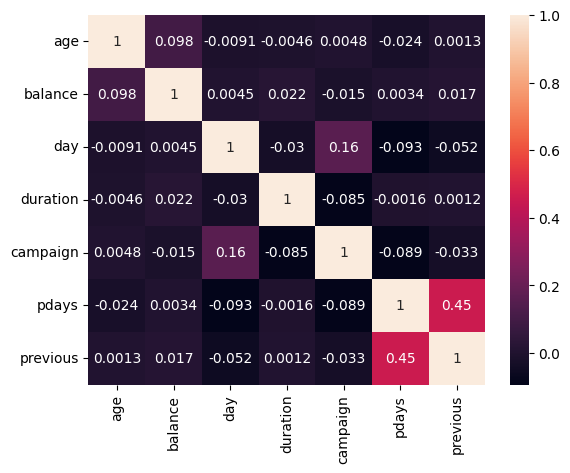

In [14]:
# Vamos a representar las correlaciones en u heatmap 
sns.heatmap(df_numericas.corr(), annot=True)

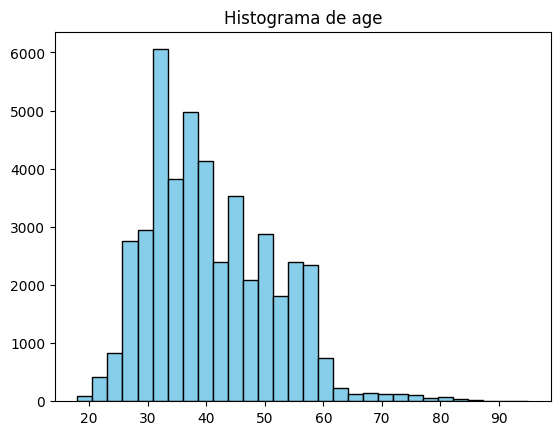

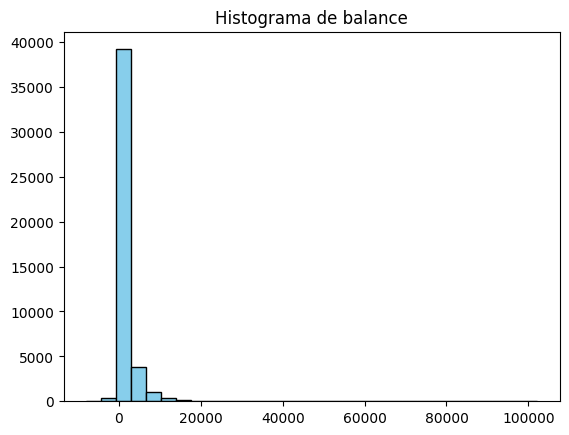

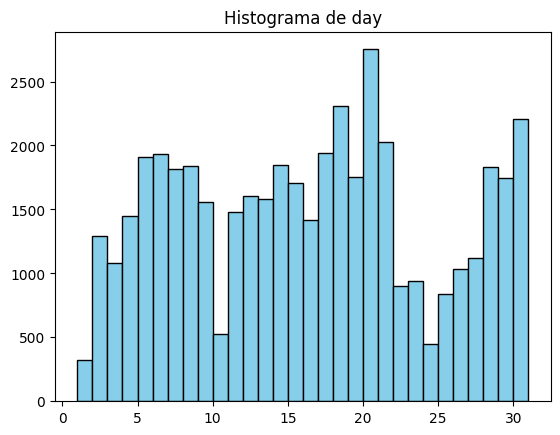

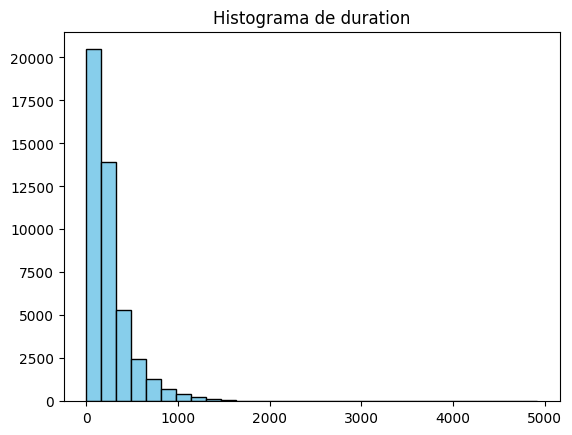

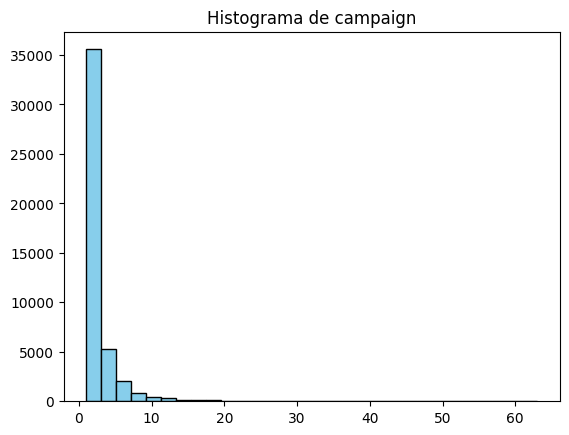

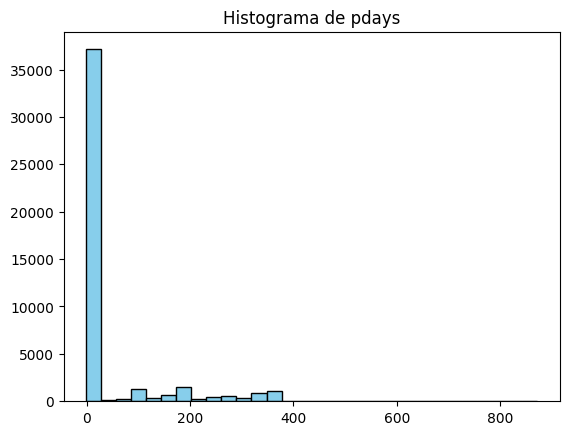

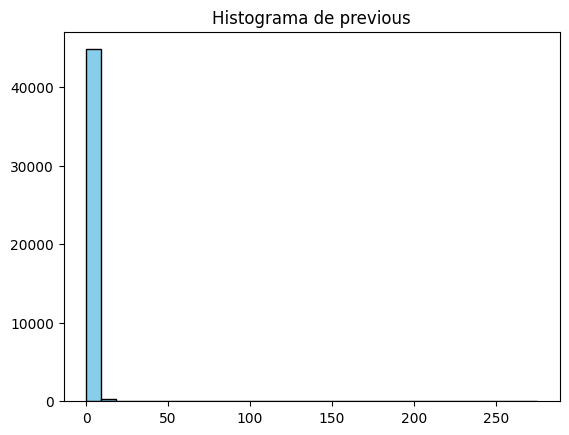

In [15]:
for col in df_numericas: 
    plt.hist(df_numericas[col],bins=30,color='skyblue',edgecolor='black')
    plt.title(f'Histograma de {col}')
    plt.show()

#### 1.2. Análisis variables categóricas

In [16]:
df_categoricas.head()

,job,marital,education,default,housing,loan,contact,poutcome,y
0,management,married,tertiary,no,yes,no,unknown,unknown,no
1,technician,single,secondary,no,yes,no,unknown,unknown,no
2,entrepreneur,married,secondary,no,yes,yes,unknown,unknown,no
3,blue-collar,married,unknown,no,yes,no,unknown,unknown,no
4,unknown,single,unknown,no,no,no,unknown,unknown,no


In [17]:
# Calcular la cardinalidad de cada columna (las distintas categorias por variable)
cardinalities = df[df_categoricas.columns].nunique() # nunique devuelve el numero de variables únicas 
print('\n',cardinalities.sort_values(ascending=False))


 job          12
education     4
poutcome      4
contact       3
marital       3
housing       2
default       2
loan          2
y             2
dtype: int64


In [18]:
# Vamos a hacer un value counts de todas las categorias que encontramos
for column in df_categoricas:
    print(f'Frecuencia de la columna {column}:') 
    print(df[column].value_counts())

Frecuencia de la columna job:
job
blue-collar      9732
management       9458
technician       7597
admin.           5171
services         4154
retired          2264
self-employed    1579
entrepreneur     1487
unemployed       1303
housemaid        1240
student           938
unknown           288
Name: count, dtype: int64
Frecuencia de la columna marital:
marital
married     27214
single      12790
divorced     5207
Name: count, dtype: int64
Frecuencia de la columna education:
education
secondary    23202
tertiary     13301
primary       6851
unknown       1857
Name: count, dtype: int64
Frecuencia de la columna default:
default
no     44396
yes      815
Name: count, dtype: int64
Frecuencia de la columna housing:
housing
yes    25130
no     20081
Name: count, dtype: int64
Frecuencia de la columna loan:
loan
no     37967
yes     7244
Name: count, dtype: int64
Frecuencia de la columna contact:
contact
cellular     29285
unknown      13020
telephone     2906
Name: count, dtype: int64
Frecu

Vemos que existen varias variables que son binarias, por lo tanto será facil cambiarlas a numéricas

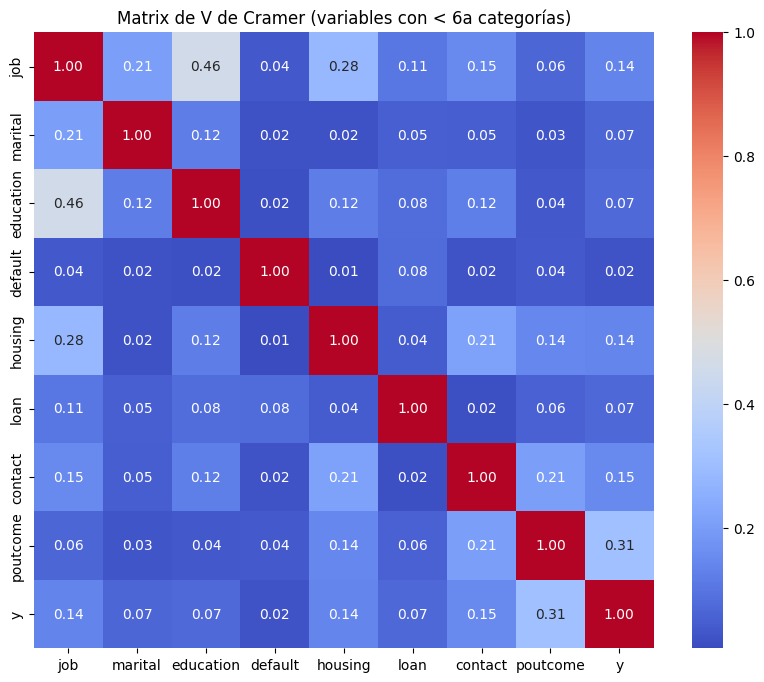

In [19]:
# Vamos a hacer la V de cramer para calcular las correlaciones entre las variables categoricas

def cramers_v (confusion_matrix):
    chi2, p, dof, expected = chi2_contingency(confusion_matrix) 
    n = confusion_matrix.sum().sum() 
    k = min(confusion_matrix.shape) 
    return np.sqrt(chi2 / (n*(k-1))) 

# Crear una matriz vacía para almacenar los valores de V de Cramer
matrix = pd.DataFrame(index=df_categoricas.columns, columns=df_categoricas.columns) 

# # Calcular V de Cramer para cada par de variables categóricas.
for var1, var2 in combinations(df_categoricas,2):
    contingency_table = pd.crosstab(df[var1],df[var2])
    value = cramers_v(contingency_table)
    matrix.loc[var1,var2] = value 
    matrix.loc[var2,var1] = value 

# Llenar la diagonal con 1s
np.fill_diagonal(matrix.values,1)  

# Convertir a tipo float
matrix = matrix.astype(float)

# Visualizar la matriz com heatmap 
plt.figure(figsize = (10,8))
sns.heatmap(matrix,annot=True,cmap='coolwarm',fmt='.2f')
plt.title('Matrix de V de Cramer (variables con < 6a categorías)')
plt.show()

¡¡¡¡¡¡ podríamos realziar también un <b> analisis de boxplot</b> para cada una de las variables con la variable objetivo !!!!!!

Para qué nos sirve:
1. Comparar distribuciones entre categorías
* Permite ver cómo varía una variable numérica dependiendo de la categoría.
* Ejemplo: comparar la distribución del ingreso (income) según el tipo de trabajo (job).

2. Detectar outliers por categoría
* Los puntos fuera de los “bigotes” del boxplot son valores atípicos.
* Esto ayuda a detectar si en alguna categoría hay datos extremos.

3. Analizar simetría y dispersión
* El tamaño de la caja muestra la dispersión (IQR) de la variable numérica para cada categoría.
* La posición de la línea central (mediana) muestra si la distribución está sesgada.

4. Identificar diferencias entre grupos
* Si las cajas de distintas categorías están muy separadas, puede indicar que esa variable categórica es relevante para explicar la variable numérica.

### 2. Conversión a numérica

Los modelos de machine learning requieren que las variables sean numéricas. Por ello, las variables categóricas deben convertirse a formato numérico. Esta conversión permitirá que el modelo procese correctamente la información categórica y pueda aprender patrones a partir de ella. Este es un proceso inicial del llamado feature engineering.

##### 1. Método One-Hot Enconding

En el anterior notebook hemos usado el siguiente método para tratar los valores categóricos <b>(One-Hot Encoding)</b>, Este metodo es recomendable para modelos lineales o basados en distancias (regresión logística, K-NN, SVM) y datasets pequeños con baja cardinalidad de las variables. 

In [20]:
lista_numericas = ['age','balance','day','duration','campaign','pdays','previous']
lista_categoricas = ['job','marital','education','month','contact','poutcome']
categoricas_binarias = ['default','housing','loan','y']

In [21]:
# Cambiamos variables binarias a si/no
for i in categoricas_binarias:
    df[i] = [0 if x =='no' else 1 for x in df[i]]

In [22]:
# Transformamos las variables a dummies
for i in lista_categoricas:
    dummies = pd.get_dummies(df[i],prefix=i) # prefix añade el nombre de i en la columna
    df = pd.concat([df,dummies],axis=1)


##### ¿Que pasa si ...

* Tenemos muchas categorias que transformar?
* Tenemos una distribución no uniforme de las categorías? 
* La transformación a dummies no funciona / no tenemos problemas de regresión? 

https://github.com/solegalli/Python-Feature-Engineering-Cookbook-First-Edition/tree/master/ch03-categorical-encoding


##### Transformación a numero ordinal

##### Método 2. "A mano". Label Encoding Manual

Hay que darle un valor con sentido. Este método se usa cuando hay un orden natural de la variable. Es correcto para modelos basados en árboles. 

##### Método 3. Asignar un valor de manera automática. Label Encoding (La peor solución de todas)

Utilizando el <b>LabelEncoder()</b> asignara un valor a cada una de las categorias ordenandolo de forma alfabética. Usado para modelos basados en árboles.

In [23]:
df['job'].unique()

array(['management', 'technician', 'entrepreneur', 'blue-collar',
       'unknown', 'retired', 'admin.', 'services', 'self-employed',
       'unemployed', 'housemaid', 'student'], dtype=object)

In [24]:
# Convertimos los valors desde 0 hasta n-1 de manera alfabética

le = LabelEncoder()
le.fit(df['job'].unique()) # Estamos probando el objeto LabelEncoder() con la variable job
print(le.classes_)
print(le.transform(df.job))

['admin.' 'blue-collar' 'entrepreneur' 'housemaid' 'management' 'retired'
 'self-employed' 'services' 'student' 'technician' 'unemployed' 'unknown']
[4 9 2 ... 5 1 2]


In [25]:
# Aplicamos el bulce for en la lista categoricas para aplicar el label encoder
for i in lista_categoricas:
    le = LabelEncoder()
    df[i + "2"] = le.fit_transform(df[i])

##### Método 4: Agrupación en valores raros. (Rare Category Grouping)

Aquellos valores que aparecen muy pocas veces en las categorias, las agrupamos en una sola categoria llamada valores raros. Tiene sentido cuando hay muchas categorias (Alta cardinalidad).

Este método es util cuando queremos:

* Reducir la dimensionalidad cuando haces one-hot encoding.
* Evitar ruido y overfitting causados por categorías con muy pocos ejemplos.
* Mejorar la estabilidad del modelo al tener categorías más robustas y bien representadas.

In [26]:
# Agrupación de valores raros
 
df['job'].value_counts(normalize=True) # Poniendo normalize = True extraemos el porcentaje

job
blue-collar      0.215257
management       0.209197
technician       0.168034
admin.           0.114375
services         0.091880
retired          0.050076
self-employed    0.034925
entrepreneur     0.032890
unemployed       0.028820
housemaid        0.027427
student          0.020747
unknown          0.006370
Name: proportion, dtype: float64

In [27]:
# Segun la teoria, a partir de menos del 5% es agrupable en una sola variable
# Utilizando el value_counts, filtramos por aquellos que sean menores al 0.05
list(df['job'].value_counts()[df['job'].value_counts(normalize=True) > 0.05].index) # Ponemos el .index para que extraiga la lista de variables (indices)

['blue-collar', 'management', 'technician', 'admin.', 'services', 'retired']

In [28]:
np.where(df['job'].isin(['blue-collar', 'management', 'technician', 'admin.', 'services', 'retired']),
         df['job'],'Rare') # Agrupamos variables menores a 0.05 como una variable Rare, deberíamos definir la variable

array(['management', 'technician', 'Rare', ..., 'retired', 'blue-collar',
       'Rare'], shape=(45211,), dtype=object)

##### Método 5: Transformación en frecuencia (Frecuency Encoding)

Cada categoria se reemplaza por su frecuencia relativa o absoluta. Captura información de cuán común es cada categoria, por lo tanto, es muy compacto. Es util para variables con alta cardinalidad donde la frecuencia tenga relación con la variable objetivo.

In [29]:
# Convertimos los valores a frecuencia (le damos un valor mayor a las clases que más aparecen/más peso tienen). ¡¡¡ Cuidado !!! dos categorias pueden tener la misma frecuencia (valores iguales)
print(df['job'].value_counts())
print(df['job'].head())

df['job'].map(df['job'].value_counts()) # la funcion map transforma los valores

job
blue-collar      9732
management       9458
technician       7597
admin.           5171
services         4154
retired          2264
self-employed    1579
entrepreneur     1487
unemployed       1303
housemaid        1240
student           938
unknown           288
Name: count, dtype: int64
0      management
1      technician
2    entrepreneur
3     blue-collar
4         unknown
Name: job, dtype: object


0        9458
1        7597
2        1487
3        9732
4         288
         ... 
45206    7597
45207    2264
45208    2264
45209    9732
45210    1487
Name: job, Length: 45211, dtype: int64

In [30]:
# Podemos osbervar que se le da el valor de la frecuencia a cada una de las categorias. Aplicamos un for para sustituir 

for i in lista_categoricas:
    df[i] = df[i].map(df[i].value_counts()) # sustitumos las frecuencias de cada categoria de job por cada una de las categorias

##### Método 6: Target Encoding

Reemplaza cada categoría por una estadística sobre la variable objetivo ( por ejemplo, la media de y por esa categoria). Maneja bien la alta cardinalidad y las categorias poco frecuentes y reduce la dimensionalidad. Tiene riesgo de overfitting (el modelo aprende demasiado bien los datos de entrenamiento).

Funciona bien con modelos lineals y no lineales. 

In [31]:
# Target mean (se sustituye por la media de la target). Cuidado, puede causar overfitting
mean_target = df.groupby('job')['y'].mean()

# Reemplazar categorias por la media
df['job_encoded'] = df['job'].map(mean_target)

print(df[['job','job_encoded']])
 

        job  job_encoded
0      9458     0.137556
1      7597     0.110570
2      1487     0.082717
3      9732     0.072750
4       288     0.118056
...     ...          ...
45206  7597     0.110570
45207  2264     0.227915
45208  2264     0.227915
45209  9732     0.072750
45210  1487     0.082717

[45211 rows x 2 columns]


In [32]:
mean_target

job
288     0.118056
938     0.286780
1240    0.087903
1303    0.155027
1487    0.082717
1579    0.118429
2264    0.227915
4154    0.088830
5171    0.122027
7597    0.110570
9458    0.137556
9732    0.072750
Name: y, dtype: float64

In [33]:
corr = abs(df.corr()) # abs sirve para aplicar el valor absoluto a toda la matriz de correlación
corr[['y']].sort_values(by ='y',ascending=False)

,y
y,1.000000
duration,0.394521
poutcome_success,0.306788
poutcome,0.176288
poutcome_unknown,0.167051
...,...
month_aug,0.008536
job_admin.,0.005637
marital_divorced,0.002772
job_self-employed,0.000855


### 3. Muestreo Estratificado

En problemas de clasificación, es fundamental que las divisiones entre entrenamiento y prueba mantengan la proporción original de las clases. Para esto utilizamos el muestreo estratificado, que asegura que ambas particiones sean representativas y evita sesgos en el entrenamiento. Esto es especialmente importante en datasets desbalanceados, donde una clase puede tener mucha más frecuencia que otra.

In [34]:
X_train, X_test, y_train, y_test  = train_test_split(df.drop('y',axis=1),
                                                     df['y'],
                                                      test_size=0.2,
                                                       random_state=42,
                                                        stratify = df['y'] ) # statify mantiene la misma porporción de variables

### 4. Modelado

En esta fase entrenamos un primer modelo de referencia (baseline) utilizando los datos preprocesados. Este modelo nos permitirá tener una línea base de rendimiento para evaluar mejoras posteriores. Inicialmente no aplicaremos un feature engineering avanzado, de modo que podamos medir el impacto real de las transformaciones y creaciones de variables que aplicaremos más adelante.

In [35]:
model1 = RandomForestClassifier()

In [36]:
model1.fit(X_train,y_train)
y_pred = model1.predict(X_test)

### 5. Métricas

Una vez entrenado el modelo, lo evaluamos utilizando métricas adecuadas según el tipo de problema. En clasificación, métricas como accuracy, precision, recall y F1-score son útiles para evaluar el rendimiento general y el balance entre falsos positivos y falsos negativos.

In [37]:
def saca_metricas(y1, y2): # Función para sacar todas las métricas necesarias para la evaluación y plotearla la curav ROC
    print('Matriz de Confusión')
    print(confusion_matrix(y1, y2)) 
    print('Accuracy:', accuracy_score(y1, y2))
    print('Precision:', precision_score(y1, y2))
    print('Recall:', recall_score(y1, y2))
    print('F1 Score:', f1_score(y1, y2))
    
    # Cálculo de la curva ROC y AUC
    false_positive_rate, recall, _ = roc_curve(y1, y2)
    roc_auc = auc(false_positive_rate, recall)
    print('AUC:', roc_auc)
    
    # Crear gráfico interactivo con Plotly
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=false_positive_rate, y=recall, mode='lines', name='Curva ROC', line=dict(color='blue')))
    fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode='lines', name='Línea base', line=dict(color='red', dash='dash')))
    
    fig.update_layout(
        title=f'Curva ROC (AUC = {roc_auc:.2f})',
        xaxis_title='False Positive Rate',
        yaxis_title='Recall',
        template='plotly_white'
    )
    
    fig.show()

In [38]:
saca_metricas(y_test, y_pred)

Matriz de Confusión
[[7772  213]
 [ 655  403]]
Accuracy: 0.9040141545947141
Precision: 0.6542207792207793
Recall: 0.3809073724007561
F1 Score: 0.48148148148148145
AUC: 0.6771161783732021


In [39]:
print(classification_report(y_test, y_pred)) # Generación del clasification report 

              precision    recall  f1-score   support

           0       0.92      0.97      0.95      7985
           1       0.65      0.38      0.48      1058

    accuracy                           0.90      9043
   macro avg       0.79      0.68      0.71      9043
weighted avg       0.89      0.90      0.89      9043



In [40]:
def plot_feature_importance(model, X_train): # Función para determinar la importancia de cada variable y luego pletarla
    feat_importances = pd.DataFrame(model.feature_importances_, index=X_train.columns, columns=["Importance"]) # Crea un DataFrame con una columna llamada importance, extrayendo de modelo feature_importances
    feat_importances.sort_values(by='Importance', ascending=False, inplace=True) # Ordena los valores de feature_importances
     
    fig = px.bar(feat_importances, x=feat_importances.index, y='Importance', title='Feature Importances', labels={'x': 'Features', 'Importance': 'Importance'}, template='plotly_white')
    fig.show()

    return feat_importances

In [41]:
plot_feature_importance(model1, X_train) # Aplicamos la función 

,Importance
duration,0.250644
balance,0.086187
age,0.082049
day,0.077488
month,0.037164
...,...
job_entrepreneur,0.001960
default,0.001636
job_housemaid,0.001600
month_dec,0.001573


### 6. Feature Engineering

En esta fase creamos, transformamos o seleccionamos características con el objetivo de mejorar el rendimiento del modelo. Esto puede incluir la creación de variables binarias, agrupación por rangos (binning), transformaciones matemáticas, reducción de dimensionalidad o combinaciones de variables. Tras realizar el feature engineering, volvemos a entrenar el modelo y a evaluar métricas, comparando los resultados con la línea base para medir la mejora obtenida.

In [42]:
def plot_target_vs_features(var, target, df): # definimos función con tres variables
    proporcion = pd.DataFrame() # crea un data frame llamado proporcion
    proporcion['%'] = df[target].groupby(df[var]).mean() * 100 # hace la media y la multiplica por 100 para cada variable del target (variable objetivo) que le digamos mediante un groupby y la almacena en el datafram con el nombre de %
    proporcion['Conteo'] = df[target].groupby(df[var]).count() #  el conteo de la variable target por variable del dataframe y la almacena en variable conteo
    proporcion = proporcion.round(3) # redondeo todos los valores del dataframe proporcion a 3
    proporcion_filtered = proporcion[(proporcion['%'] > 0) & (proporcion['Conteo'] > 10)] # filtra porporcion por aquellos que tienen un % mayor que 0 y con conteo mayor que 10
    
    if len(proporcion_filtered) < 100 and len(proporcion_filtered) > 1: 
        fig = px.bar(proporcion_filtered, x=proporcion_filtered.index, y='Conteo', title=f'Distribución de {var}', labels={'x': var, 'Conteo': 'Cantidad'}, template='plotly_white')
        fig.add_trace(go.Scatter(x=proporcion_filtered.index, y=proporcion_filtered['%'], mode='lines+markers', name='%', yaxis='y2', line=dict(color='green')))
        
        fig.update_layout(
            yaxis2=dict(title='%', overlaying='y', side='right')
        )
    elif len(proporcion_filtered) >= 100:
        df_filtered = df[[var, target]].dropna()
        df_filtered['bin'] = pd.qcut(df_filtered[var], q=20, duplicates='drop')
        bin_means = df_filtered.groupby('bin')[target].mean() * 100
        bin_counts = df_filtered.groupby('bin')[target].count()
        
        fig = go.Figure()
        fig.add_trace(go.Bar(x=bin_means.index.astype(str), y=bin_counts, name='Conteo', yaxis='y', marker_color='blue'))
        fig.add_trace(go.Scatter(x=bin_means.index.astype(str), y=bin_means, mode='lines+markers', name='%', yaxis='y2', line=dict(color='green')))
        
        fig.update_layout(
            title=f'Relación entre {var} y {target}',
            xaxis_title=f'Binned {var}',
            yaxis=dict(title='Conteo'),
            yaxis2=dict(title='%', overlaying='y', side='right'),
            template='plotly_white'
        )
    else:
        proporcion_filtered.reset_index(inplace=True)
        fig = px.scatter(proporcion_filtered, x=var, y='%', trendline='ols', title=f'Relación entre {var} y % Depósitos', template='plotly_white') # aplica un if para dibujar en función de la domensión de porporcion_filtered
    
    fig.show()

    # Tiene una representación en linea del porcentaje y una representacciones en barras del conteo

In [43]:
for i in df.columns: # este porceso lo ara para cada columna de df con un bucle for
    plot_target_vs_features (i, 'y', df)

C:\Users\pauri\AppData\Local\Temp\ipykernel_2272\919833204.py:18: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\pauri\AppData\Local\Temp\ipykernel_2272\919833204.py:19: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



C:\Users\pauri\AppData\Local\Temp\ipykernel_2272\919833204.py:18: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\pauri\AppData\Local\Temp\ipykernel_2272\919833204.py:19: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



C:\Users\pauri\AppData\Local\Temp\ipykernel_2272\919833204.py:18: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\pauri\AppData\Local\Temp\ipykernel_2272\919833204.py:19: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



##### Método 1: Feature Creation mediante reglas y variables binarias

* Creación manual de nuevas variables usando funciones lambda.
* Variables binarias, categóricas, o rangos simples basados en condiciones lógicas.

In [44]:
## AGE (realizamos una variable con 3 rangos de edad y 3 variables con esos mismos rangos)
df['age_joven'] = df['age'].apply(lambda x: 1 if x<=35 else 0)
df['age_adulto'] = df['age'].apply(lambda x: 1 if x>35 & x<60 else 0)
df['age_jubilado'] = df['age'].apply(lambda x: 1 if x>60 else 0)
df['age_new'] = df['age'].apply(lambda x: 0 if x<=35 else (1 if x>35 and x<60 else(2))) 

## CAMPAIGN (observamos que la mitad de los datos están entre 1 y 2, creamos una nueva clase para el resto)
df['campaign_new'] = df['campaign'].apply(lambda x: 0 if x<=15 else 1)
df['campaign_new2'] = df['campaign'].apply(lambda x: 1 if x==1 else (2 if x==2 else(3))) 

## PDAYS (casi todos los datos están en -1 (no contactado), por tanto, transformamos la variable en contactados y no contactados)
df['pdays_new5'] = df['pdays'].apply(lambda x: 0 if x<=0 else (1 if x<7 else(2 if x>=7 and x<14 else(3))))
df['pdays_new'] = df['pdays'].apply(lambda x: 0 if x==-1 else x)
df['pdays_new2'] = df['pdays']//30
df['pdays'] = df['pdays'].apply(lambda x: 0 if x==-1 else x)
df['pdays_new2'] = df['pdays_new2'].apply(lambda x: 0 if x==-1 else x)
df['pdays_new3'] = df['pdays_new2'].apply(lambda x: 0 if x<=0 else x)

## PREVIOUS (al igual que anteriormente, la mayoría no han sido contactados anteriormente, creamos una variable binaria)
df['previous_new'] = df['previous'].apply(lambda x: 0 if x == 0 else 1)
df['previous_new_2'] = df['previous'].apply(lambda x: 0 if x == 0 else 1)

df['previous_new_2'] = df['previous_new_2'].apply(lambda x: 0 if x<=0 else x)

## BALANCE (en este caso, hacemos tramos de la variable)    
df['balance_new'] = df['balance'].apply(lambda x: 0 if x<=0 else x)
df['balance_negativo'] = df['balance'].apply(lambda x: 1 if x<=0 else 0)
df['balance_new2'] = df['balance'].apply(lambda x: 0 if x<=100 else (1 if x>100 and x<=500 else(2 if x>500 and x<=2000 else(3 if x>2000 and x<10000 else(4)))))
df['balance'] = df['balance'].apply(lambda x: 0 if x<=0 else x)

## JOB (podemos hacer una variable de empleado y no empleado)
df['job_new'] = df['job'].apply(lambda x: 1 if x==5 or x ==8 or x==10  else 0)

##### Método 2: Feature Transformation mediante binning (agrupación en tramos o intervalos)
* Agrupación automática de variables numéricas continuas en intervalos o bins usando divisiones enteras y límites máximos.
* Permite transformar variables continuas en rangos discretos de forma sistemática. 

In [45]:
def tramos(varib,varib_destino,tamanio,maximo,df): # define uma variable llamada tramos con las siguientes variables (varib,varib_destino,tamanio,maximo,df)
    df[varib_destino]=np.where(df[varib]==0,-1,(df[varib]//tamanio)*tamanio) # asignamos el resultado a una nueva columna llamada varib_destino, si el valor es 0, asignamos -1 si no es 0 asignamos la division entera del valor de la variable entre tamanio * tamanio
    df[varib_destino]=np.where(df[varib_destino]>=maximo,maximo,df
                               [varib_destino]) # asignamos el valor de maximo cuando el resultado anterior es mayot que el maximo, y sino pues le asignamos el valor anterior, guardandolo en la misma variable

In [46]:
tramos('duration','duration_new',5,4900,df) # se aplica la función anterior
df['duration_new'] = df['duration_new'].apply(lambda x: 0 if x<=0 else x)  # aplicamos la función condicional de darle valo 0 cuando es menor o igual que 0 y x cuando no se cumple
df['duration_new2'] = df['duration_new']//60 # dividimos enteramente ese valor entre 60

In [47]:
tramos('pdays_new2','pdays_new3',2,14,df) # aplicamos la funcion a pdays_news2
tramos('previous','previous_new_2',2,10,df) # aplicamos la funcion a previous
tramos('day','day_new',15,31,df) # aplicamos la funcion a days
tramos('balance','balance_new',500,10000,df) # aplicamos la funcion a balance

##### Método 3: Feature Creation mediante agregación matemática de variables

* Creación de nuevas variables combinando varias existentes a través de funciones estadísticas o matemáticas.
* Se generan variables que resumen o condensan información de múltiples columnas.

In [48]:
features = ['duration' , 'age'] # crea un arary con dos variables

In [49]:
df["mean_duration-age"] = df[features].mean(axis=1) # crea una nueva columna en el df inicial filtrando por ese array inicial y aplicando la media. 

In [50]:
math_func = ["sum", "prod", "mean", "std", "max", "min"] # crea un array con las funciones a aplicar

In [51]:
df[features].agg(math_func, axis="columns") # filtrando por features en df, aplica las funciones creadas en el array anterior

,sum,prod,mean,std,max,min
0,319.0,15138.0,159.5,143.542677,261.0,58.0
1,195.0,6644.0,97.5,75.660426,151.0,44.0
2,109.0,2508.0,54.5,30.405592,76.0,33.0
3,139.0,4324.0,69.5,31.819805,92.0,47.0
4,231.0,6534.0,115.5,116.672619,198.0,33.0
...,...,...,...,...,...,...
45206,1028.0,49827.0,514.0,654.780879,977.0,51.0
45207,527.0,32376.0,263.5,272.236111,456.0,71.0
45208,1199.0,81144.0,599.5,745.997654,1127.0,72.0
45209,565.0,28956.0,282.5,318.905158,508.0,57.0


### 7. Transformación de variables continuas (numéricas)

(array([3.9677e+04, 4.4250e+03, 8.6500e+02, 1.7600e+02, 4.3000e+01,
        1.1000e+01, 1.1000e+01, 2.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([   0. ,  491.8,  983.6, 1475.4, 1967.2, 2459. , 2950.8, 3442.6,
        3934.4, 4426.2, 4918. ]),
 <BarContainer object of 10 artists>)

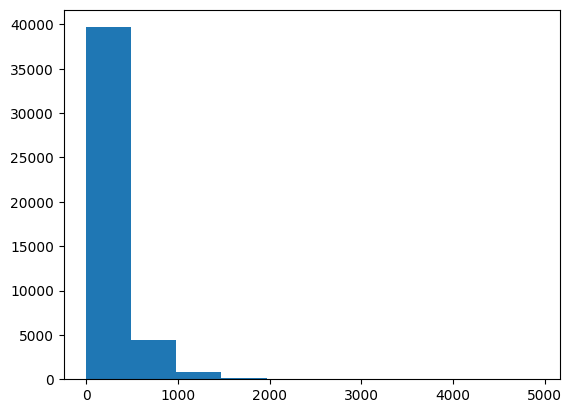

In [52]:
plt.hist(df['duration'])

##### Método 1: Transformación de Variables Numéricas con Yeo-Johnson

técnica que permite estabilizar la varianza y hacer que la distribución de una variable numérica sea más parecida a una distribución normal. Yeo-Johnson puede aplicarse tanto a valores positivos como negativos, e incluso ceros, lo que la hace muy útil en casos donde los datos contienen estos valores. Esta transformación es especialmente valiosa para mejorar el rendimiento de modelos que asumen normalidad en las variables de entrada.

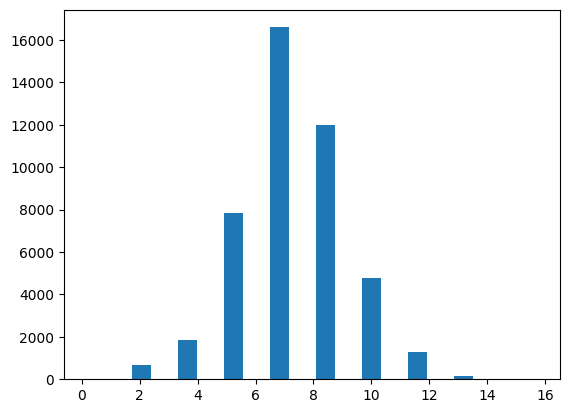

In [53]:
from scipy.stats import yeojohnson

plt.hist(yeojohnson(df['duration'])) # lo aplicamos sobre la variable duration, que no tenia una distribución normal
plt.show()

##### Método 2: Transformación de Box-Cox
Técnica utilizada para transformar variables numéricas <b>positivas</b> con el fin de aproximar su distribución a una normal. Esta transformación requiere que los datos sean estrictamente positivos, ya que no puede aplicarse a valores cero o negativos. Box-Cox ayuda a estabilizar la varianza y mejorar la simetría de los datos, lo cual es beneficioso para muchos algoritmos estadísticos y modelos predictivos que suponen normalidad en las variables.

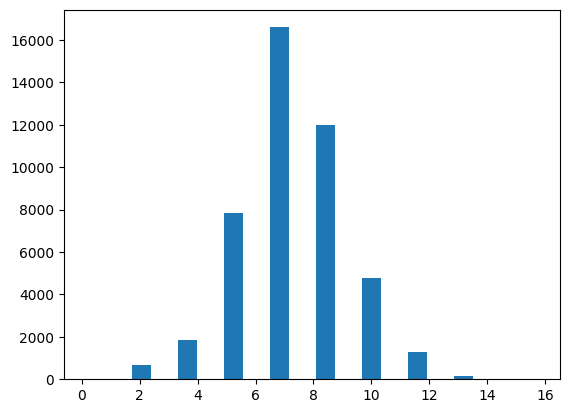

In [54]:
from scipy.stats import yeojohnson

plt.hist(yeojohnson(df['duration'])) # aplicamos sobre duration
plt.show()

##### Método 3: Estandarización (Z-score Scaling)
La estandarización transforma las variables para que tengan media cero y desviación estándar uno. Esto es útil cuando quieres que los datos estén centrados y comparables, especialmente para algoritmos que asumen que las variables están distribuidas normalmente o que son sensibles a la escala, como regresión lineal, SVM o redes neuronales.


In [55]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
prueba_escalado = sc.fit_transform(df)

##### Método 4: Normalización (Min-Max Scaling)
La normalización escala las variables para que sus valores estén en un rango específico, usualmente entre 0 y 1. Esto es útil para algoritmos que dependen de la distancia entre puntos, como k-NN o redes neuronales, garantizando que ninguna variable domine por tener rangos mayores.

In [56]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
prueba_escalado = scaler.fit_transform(df)

##### Método 5: Discretización con KBinsDiscretizer
La discretización es el proceso de transformar variables numéricas continuas en variables categóricas dividiendo el rango de valores en intervalos o bins. El método KBinsDiscretizer de scikit-learn permite hacer esto de manera automática usando distintas estrategias (uniforme, cuantiles, k-means). En este caso, la estrategia uniforme divide el rango de la variable en intervalos iguales. Esta técnica es útil para convertir variables numéricas en categorías, facilitando ciertos tipos de análisis o modelos que prefieren variables discretas.

In [57]:
from sklearn.preprocessing import KBinsDiscretizer
est = KBinsDiscretizer(
    n_bins=20, encode='ordinal', strategy='uniform'
)
est.fit_transform(df[['age']])


array([[10.],
       [ 6.],
       [ 3.],
       ...,
       [14.],
       [10.],
       [ 4.]], shape=(45211, 1))

In [58]:
corr = abs(df.corr())
corr[['y']].sort_values(by = 'y',ascending=False)

,y
y,1.000000
mean_duration-age,0.395298
duration_new,0.394555
duration,0.394521
duration_new2,0.393241
...,...
job_admin.,0.005637
marital_divorced,0.002772
job_self-employed,0.000855
job_unknown,0.000267


### 8. Muestreo estratificado

In [59]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('y',axis=1),
                                                    df.y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify = df['y'])

### 9. Selección de variables

##### Método 1: Correlación de las variables

In [60]:
list(corr[['y']].sort_values(by = 'y', ascending = False).index)

['y',
 'mean_duration-age',
 'duration_new',
 'duration',
 'duration_new2',
 'poutcome_success',
 'poutcome',
 'pdays_new5',
 'previous_new',
 'poutcome_unknown',
 'month',
 'age_jubilado',
 'contact_unknown',
 'contact2',
 'previous_new_2',
 'housing',
 'job_encoded',
 'contact_cellular',
 'month_mar',
 'month_oct',
 'month_sep',
 'contact',
 'pdays_new3',
 'pdays',
 'pdays_new',
 'month_may',
 'pdays_new2',
 'balance_new2',
 'previous',
 'job_retired',
 'poutcome2',
 'campaign_new2',
 'job_student',
 'month_dec',
 'campaign',
 'job_blue-collar',
 'loan',
 'education_tertiary',
 'education2',
 'balance_negativo',
 'month_apr',
 'balance_new',
 'marital_single',
 'marital_married',
 'job',
 'balance',
 'marital',
 'marital2',
 'job2',
 'education_primary',
 'month_feb',
 'education_secondary',
 'month_jul',
 'job_management',
 'poutcome_other',
 'campaign_new',
 'age_joven',
 'day',
 'job_services',
 'age',
 'month2',
 'age_new',
 'default',
 'day_new',
 'job_unemployed',
 'job_entrepr

In [61]:
lista_final = [ 'mean_duration-age',
 'duration_new',
 'poutcome_success',
 'pdays_new5',
 'previous_new',
 'poutcome_unknown',
 'month',
 'age_jubilado',
 'contact_unknown',
 'housing',
 'job_encoded',
 'contact_cellular',
 'balance_new2',
 'job_retired',
 'job_student',
 'marital_single',
 'marital_married',
 'education_primary']

In [62]:
model = RandomForestClassifier().fit(X_train[lista_final],y_train)
y_pred = model.predict(X_test[lista_final])

In [63]:
saca_metricas(y_test, y_pred)

Matriz de Confusión
[[7661  324]
 [ 603  455]]
Accuracy: 0.8974897710936636
Precision: 0.5840821566110398
Recall: 0.43005671077504726
F1 Score: 0.4953728905824714
AUC: 0.6947403153123827


##### Método 2: Feature importances

In [64]:
model = RandomForestClassifier().fit(X_train,y_train)
y_pred = model.predict(X_test)

In [65]:
feature_importance = plot_feature_importance(model,X_train)

In [66]:
feature_importance[:30]

,Importance
mean_duration-age,0.099057
duration,0.088487
duration_new,0.081209
duration_new2,0.051878
age,0.045649
day,0.043476
balance,0.043069
month,0.039536
month2,0.026115
poutcome_success,0.025955


In [67]:
feature_importance.index

Index(['mean_duration-age', 'duration', 'duration_new', 'duration_new2', 'age',
       'day', 'balance', 'month', 'month2', 'poutcome_success', 'poutcome',
       'balance_new', 'campaign', 'job_encoded', 'pdays_new', 'pdays',
       'housing', 'job', 'job2', 'balance_new2', 'day_new', 'campaign_new2',
       'poutcome2', 'education2', 'pdays_new2', 'education', 'age_new',
       'previous', 'month_jun', 'pdays_new3', 'marital', 'marital2',
       'contact2', 'age_jubilado', 'marital_married', 'education_secondary',
       'previous_new_2', 'age_adulto', 'month_apr', 'education_tertiary',
       'month_mar', 'loan', 'age_joven', 'contact', 'month_may',
       'job_management', 'job_technician', 'marital_single',
       'contact_cellular', 'contact_unknown', 'month_aug', 'month_nov',
       'month_feb', 'month_jul', 'poutcome_failure', 'job_admin.',
       'job_blue-collar', 'marital_divorced', 'balance_negativo',
       'education_primary', 'job_services', 'month_oct', 'month_jan',
   

In [68]:
lista_final2 = ['duration_new', 'mean_duration-age', 'age',
       'day', 'balance', 'month', 'poutcome', 'campaign', 'pdays', 'job_encoded',
       'housing', 'education2']

In [69]:
model = RandomForestClassifier().fit(X_train[lista_final2],y_train)
y_pred = model.predict(X_test[lista_final2])

In [70]:
saca_metricas(y_test, y_pred)

Matriz de Confusión
[[7727  258]
 [ 599  459]]
Accuracy: 0.9052305650779608
Precision: 0.6401673640167364
Recall: 0.43383742911153117
F1 Score: 0.5171830985915493
AUC: 0.7007634233848201


##### Método 3: SelectKbest 

Suele utilizarse para automatizarlo

In [71]:
selection = SelectKBest( k =20)
feature_selection = selection.fit_transform(df.drop('y',axis=1),df['y'])

variables  = list (np.asarray(list(df.drop('y',axis=1)))[selection.get_support()])
variables.sort()
print(variables)

[np.str_('age_jubilado'), np.str_('contact2'), np.str_('contact_cellular'), np.str_('contact_unknown'), np.str_('duration'), np.str_('duration_new'), np.str_('duration_new2'), np.str_('housing'), np.str_('job_encoded'), np.str_('mean_duration-age'), np.str_('month'), np.str_('month_mar'), np.str_('month_oct'), np.str_('month_sep'), np.str_('pdays_new5'), np.str_('poutcome'), np.str_('poutcome_success'), np.str_('poutcome_unknown'), np.str_('previous_new'), np.str_('previous_new_2')]


C:\Users\pauri\AppData\Roaming\Python\Python313\site-packages\sklearn\feature_selection\_univariate_selection.py:111: UserWarning:

Features [76] are constant.

C:\Users\pauri\AppData\Roaming\Python\Python313\site-packages\sklearn\feature_selection\_univariate_selection.py:112: RuntimeWarning:

invalid value encountered in divide



##### Método 4 Variance Thresold

In [72]:
from sklearn.feature_selection import VarianceThreshold
selector = VarianceThreshold(threshold=0.6) # Porcentaje de la varianza que recogemos
selector.fit_transform(df)

array([[5.8000e+01, 9.4580e+03, 2.7214e+04, ..., 4.0000e+00, 0.0000e+00,
        1.5950e+02],
       [4.4000e+01, 7.5970e+03, 1.2790e+04, ..., 2.0000e+00, 0.0000e+00,
        9.7500e+01],
       [3.3000e+01, 1.4870e+03, 2.7214e+04, ..., 1.0000e+00, 0.0000e+00,
        5.4500e+01],
       ...,
       [7.2000e+01, 2.2640e+03, 2.7214e+04, ..., 1.8000e+01, 1.5000e+01,
        5.9950e+02],
       [5.7000e+01, 9.7320e+03, 2.7214e+04, ..., 8.0000e+00, 1.5000e+01,
        2.8250e+02],
       [3.7000e+01, 1.4870e+03, 2.7214e+04, ..., 6.0000e+00, 1.5000e+01,
        1.9900e+02]], shape=(45211, 29))

In [73]:
selector.get_feature_names_out()

array(['age', 'job', 'marital', 'education', 'balance', 'contact', 'day',
       'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome',
       'job2', 'month2', 'contact2', 'poutcome2', 'campaign_new2',
       'pdays_new5', 'pdays_new', 'pdays_new2', 'pdays_new3',
       'previous_new_2', 'balance_new', 'balance_new2', 'duration_new',
       'duration_new2', 'day_new', 'mean_duration-age'], dtype=object)

### 10. Tuneo de hiperparámetros

Es el proceso de encontrar los valores óptimos de los hiperparámetros de un modelo para mejorar su rendimiento.

In [74]:
grid_param = {
    'n_estimators':[50,200], #Número de árbboles
    'max_depth':[22,24] # Profundidad del RF
} # Cuantos más hiperparmetros mas iteraciones (entrenamiento), se pueden ir cambiando los parámetros para ir tratando de mejorar la capacidad de predicción

In [75]:
model_grid = GridSearchCV( 
    estimator = model,
    param_grid= grid_param,
    scoring = 'f1',
    cv = 5, # particiiones del dataset para entrenar y validar el modelo
    n_jobs = -1
) # Sirve para saber cuales son los mejores parametros antes propuestos que dan mejores resultados en socring (en este caso f1)

In [76]:
model_grid.fit(X_train[lista_final2], y_train)
print(model_grid.best_params_)
print(model_grid.best_score_)


{'max_depth': 22, 'n_estimators': 200}
0.5135631001542139


In [77]:
model3 = RandomForestClassifier(max_depth=22, n_estimators=200).fit(X_train[lista_final2],y_train)
y_pred = model3.predict(X_test[lista_final2])

In [78]:
saca_metricas(y_test,y_pred)

Matriz de Confusión
[[7722  263]
 [ 597  461]]
Accuracy: 0.9048988167643481
Precision: 0.6367403314917127
Recall: 0.43572778827977315
F1 Score: 0.5173961840628507
AUC: 0.7013955159307445


In [79]:
y_train.value_counts() # Nuestro modelo no puede dar mejores resultados pork los datos estan desbalanceados.

y
0    31937
1     4231
Name: count, dtype: int64

### 11. Balanceo de datos

Se trata de ajustar la distribución de las clases en tu dataset para que el modelo no se vea sesgado hacia la clase mayoritaria.

* Método 1: Undersampling: consiste en seleccionar un porcentaje de muestrar de la clase mayoritaria 
* Método 2: Oversamplit: consiste en duplicar un porcentaje de muestrar de la clase minoritaria. (Es mas recomendable)

Es mejor no igualar los datos, pues se pierde capacidad predictiva del modelo.

La libreria tradicional de ML es: https://imbalanced-learn.org/stable/ 

In [80]:
df['y'].value_counts()

y
0    39922
1     5289
Name: count, dtype: int64

In [81]:
X_train = X_train[lista_final2]
X_test = X_test[lista_final2]

In [82]:
# Apicamos el oversamplig SMOTE

print('Antes Oversampling, numero de 1:{}'.format(sum(y_train==1)))
print('Antes Oversampling, numero de 0:{}'.format(sum(y_train==0)))

sm = SMOTE(random_state=2, sampling_strategy=0.3) # Porcentaje de categorias que yo quiero crear

X_train_res, y_train_res = sm.fit_resample(X_train, y_train.ravel())

print('Despúes Oversampling, la shape de X_train:{}'.format(X_train_res.shape))
print('Después Oversampling, la shape de y_train:{}'.format(y_train_res.shape))
print('Después Oversampling, numero de 1:{}'.format(sum(y_train_res==1)))
print('Después Oversampling, numero de 0:{}'.format(sum(y_train_res==0)))



Antes Oversampling, numero de 1:4231
Antes Oversampling, numero de 0:31937
Despúes Oversampling, la shape de X_train:(41518, 12)
Después Oversampling, la shape de y_train:(41518,)
Después Oversampling, numero de 1:9581
Después Oversampling, numero de 0:31937


C:\Users\pauri\AppData\Local\Temp\ipykernel_2272\3918961921.py:8: FutureWarning:

Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.



In [83]:
model4 = RandomForestClassifier().fit(X_train_res, y_train_res)
y_pred = model4.predict(X_test)

In [84]:
saca_metricas(y_test,y_pred)

Matriz de Confusión
[[7530  455]
 [ 464  594]]
Accuracy: 0.8983744332632976
Precision: 0.5662535748331744
Recall: 0.5614366729678639
F1 Score: 0.5638348362600855
AUC: 0.7522274160080397


In [85]:
# Valdidación cruzada
results = cross_val_score(estimator=model4, X = X_train_res, y = y_train_res, cv =5)

In [86]:
results

array([0.87283237, 0.87813102, 0.91738921, 0.92400337, 0.92737565])

In [87]:
print(results.mean())

0.9039463241575056


In [88]:
print(results.std())

0.023522064361016445


### 12. Automaitzación

Hay un proceso que sirve para automatizar todo lo anterior, lo que no es para nada fiable y, por lo tanto, es simplemente una aproximación.

* SimpleImputer: nos permite imputar datos en abse a diferentes estrategias
* OneHotEncoder: Hace lo mis o que el pd.get_dummies pero se ejecuta como LabelEncoder
* ColumnTransformer: permite hacer transformaciones (las que queramos, ejemplo, las de SimpleImputer) por columna
* Pipeline: permite ejecutar un flujo en el orden que digamos (automatización de procesos de ML)

In [90]:
data = pd.read_csv('C:/Users/pauri/OneDrive/Escritorio/4) MÁSTER EN DATA SCIENCE, BIG DATA & BUSINESS ANALYTICS (UCM)/MÓDULO 8_MACHINE LEARNING/Clase 5, 6, 7 y 8/1. Ejercicio_banco/bank-full.csv', sep=';')


X =  data.drop(columns=['y'])
y = data['y'].map({'no':0, 'yes':1})

num_features = X.select_dtypes(include=[np.number]).columns.tolist()
cat_features = X.select_dtypes(exclude=[np.number]).columns.tolist()


# Preprocesamiento de datos

num_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer( 
    transformers = [
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)
    ]
)

# Definir modelos y sus hiperparametors

models = {
    'DecisionTree': DecisionTreeClassifier(),
    'RandomForest': RandomForestClassifier()
}

param_grid = {
    'DecisionTree': {
        'classifier__max_depth': [3,5,10,None],
        'classifier__min_samples_split': [2,5,10],
        'classifier__min_samples_leaf': [1,2,4]
    },
    'RandomForest':{
        'classifier__n_estimators': [50,100,200],
        'classifier__max_depth': [3,5,10,None],
        'classifier__min_samples_split':[2,5,10],
        'classifier__min_samples_leaf': [1,2,4]
    }
}

X_train, X_test, y_train, y_test = train_test_split (X,y,test_size=0.2,random_state=42, stratify = y)

# realizar GridSearch para cada modelo

best_models = {}

for name, model in models.items():
    pipeline= Pipeline(steps = [
        ('preprocessor', preprocessor),
        ('classifier',model)
    ])

grid_search = GridSearchCV(pipeline, param_grid[name],cv=5, scoring = 'accuracy',n_jobs = -1)
grid_search.fit(X_train, y_train)

best_models[name] = grid_search.best_estimator_
print(f'Mejor modelo para {name}: {grid_search.best_params_}, Mejor Score: {grid_search.best_score_}')

# Evaluar en datos de prueba

for name, model in best_models.items():
    test_score = model.score(X_test,y_test)
    print(f'Precisión en test para {name}: {test_score}')



Mejor modelo para RandomForest: {'classifier__max_depth': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}, Mejor Score: 0.905938988587198
Precisión en test para RandomForest: 0.9067787238748203


### 13. Scripts/Entregables

Usaremos la libreria picke que sirve para serialziar y deserializar objetos.

* Serializar (pickling): convertir un objeto de Python (listas, diccionarios, modelos entrenados, etc.) en una secuencia de bytes para poder guardarlo en un archivo o enviarlo por red.

* Deserializar (unpickling): hacer la operación inversa: leer esos bytes y reconstruir el objeto original en memoria.

In [ ]:
import pickle # Sirve para guardar nuestro modelo
 
pkl_filename = 'modelo.pkl' 

with open(pkl_filename, 'wb') as file:
    pickle.dump(model,file)

In [92]:
# Load from file 

pkl_filename = 'modelo.pkl'

with open (pkl_filename, 'rb') as file:
    model = pickle.load(file)


In [93]:
model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'balance', 'day',
                                                   'duration', 'campaign',
                                                   'pdays', 'previous']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'month', 'poutcome'])])),
                ('classifier', RandomForestClassifier(n_estimators=200))])

In [94]:
y_pred = model.predict(X_test)

In [95]:
y_pred

array([0, 0, 0, ..., 0, 0, 0], shape=(9043,))

In [96]:
model.predict_proba(X_test)[:0]

array([], shape=(0, 2), dtype=float64)

In [97]:
model.predict_proba(X_test)[:,1]

array([0.   , 0.   , 0.005, ..., 0.02 , 0.16 , 0.025], shape=(9043,))

In [98]:
X_test.head(5)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
1392,40,blue-collar,married,primary,no,640,yes,yes,unknown,8,may,347,2,-1,0,unknown
7518,44,technician,married,secondary,no,378,yes,no,unknown,30,may,203,2,-1,0,unknown
12007,31,services,married,secondary,no,356,yes,no,unknown,20,jun,228,5,-1,0,unknown
5536,36,blue-collar,married,primary,no,655,yes,no,unknown,23,may,153,4,-1,0,unknown
29816,34,services,single,secondary,no,1921,yes,no,cellular,4,feb,61,1,-1,0,unknown
